In [12]:
using Pkg
Pkg.activate(".")

using Revise, PtyLab, TestImages, ImageShow, IndexFunArrays, FFTW, HDF5, Noise, FourierTools, CUDA
using EllipsisNotation
FFTW.set_num_threads(12)

  Activating project at `~/.julia/dev/PtyLab.jl/examples`


## Object

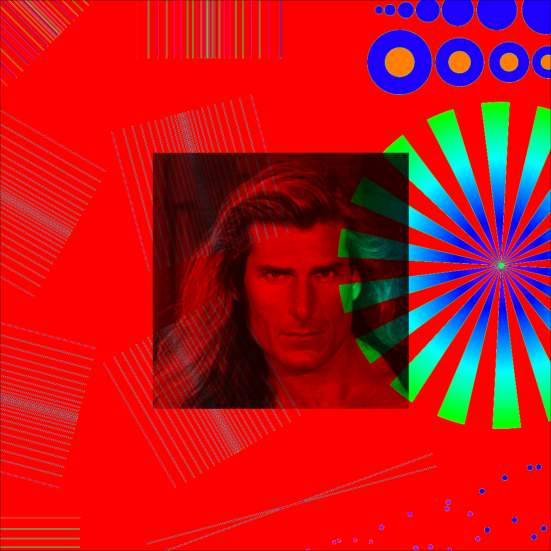

In [13]:
img_abs = ones(Float32, (1920, 1920))
FourierTools.center_set!(img_abs, Float32.(testimage("fabio_gray_512")))

img_phase = Float32.(testimage("resolution_test_1920"))
object = (img_abs .* cispi.(2 .* img_phase))[400:1500, 400:1500]

simshow(object)

## Random Grid

grr.overlap = (0.9133333333333333, 0.9133333333333333)


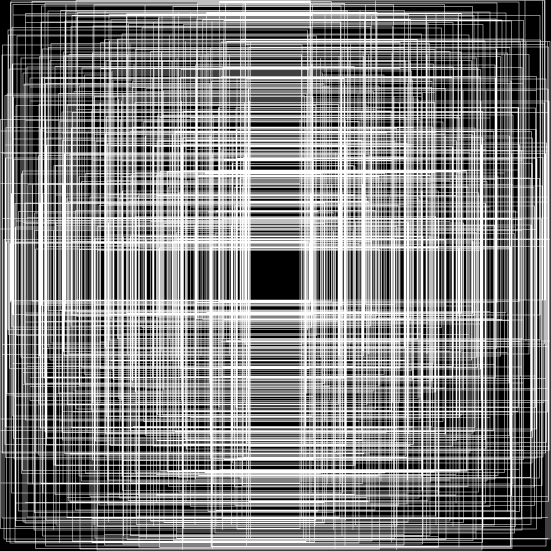

In [22]:
grid_size = size(object)
tile_size = (600, 600)

grr = PtyLab.grid_regular_rand(grid_size, tile_size, (20, 20), 30);
@show grr.overlap
show_grid(grr, only_points=false)

## Probe

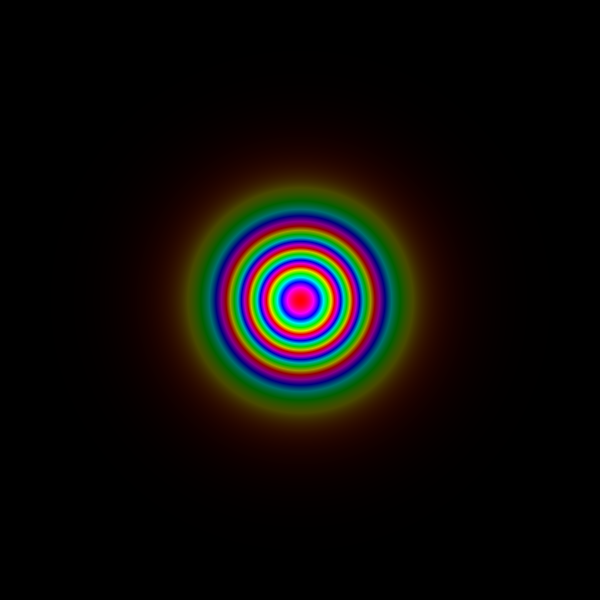

In [15]:
probe = IndexFunArrays.gaussian(Float32, tile_size, scale=0.00020) .* cis.(Float32(2π) .* 
     4 .* gaussian(Float32, tile_size, scale=0.0005));

simshow(probe)

## Simulate and store as dataset

In [16]:
ptychogram = zeros(Float32, (tile_size..., length(grr.tiles)));
p = Params()
o2d, d2o = Fraunhofer(probe, fftshiftSwitch=true);

for (i, t) in enumerate(grr.tiles)
    ptychogram[:, :, i] = abs2.(o2d(view(object, t.i₁:t.i₂,  t.j₁:t.j₂) .* probe))#, 200000)
end


lambda = 633f-9
z = 50f-3
dxd = 10f-6
Nd = size(ptychogram, 1)
dxo = lambda * z / (Nd * dxd)

fid_new = h5open("simulated_ptychography.hdf5", "w");
fid_new["Nd"] = Nd
fid_new["No"] = size(img_abs, 1)
fid_new["dxd"] = 10f-6

enc = PtyLab.encoder(grr, dxo, offset=(50, 50))
fid_new["encoder"] = enc .- maximum(enc) / 2
fid_new["wavelength"] = lambda
fid_new["entrancePupilDiameter"] = dxo * 50
fid_new["zo"] = z
fid_new["ptychogram"] = ptychogram
close(fid_new)
#@view_image ptychogram;

## Load dataset again

In [17]:
experimentalData = ExperimentalDataCPM("simulated_ptychography.hdf5");

reconstruction = ReconstructionCPM(experimentalData, cuda=false);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);



┌ Info: Reading HDF5.File: (read-only) simulated_ptychography.hdf5 was successful
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/ExperimentalData.jl:63
┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/utils_calc.jl:91


### On CPU

In [18]:
reconstruction = ReconstructionCPM(experimentalData, cuda=false);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

engine = PtyLab.ePIE(betaProbe = 0.75f0, betaObject = 0.75f0, numIterations = 20)
params2 = Params(transposePtychogram = false, comStabilizationSwitch = true, fftshiftSwitch = false);


reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

CUDA.@time p, o = PtyLab.reconstruct(engine, params2, reconstruction);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/utils_calc.jl:91
┌ Warning: gimmel is currently estimated as `eps(Float32)`
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/Engines.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


 69.421849 seconds (3.46 M CPU allocations: 982.434 MiB, 0.33% gc time), 0.00% GPU memmgmt time


## On GPU

In [19]:
empty!(Out)
GC.gc()

reconstruction = ReconstructionCPM(experimentalData, cuda=true);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

reconstruction = PtyLab.initializeObjectProbe!(reconstruction);
CUDA.@time p, o = PtyLab.reconstruct(engine, params2, reconstruction);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/utils_calc.jl:91
┌ Warning: gimmel is currently estimated as `eps(Float32)`
└ @ PtyLab /home/fxw/.julia/dev/PtyLab.jl/src/Engines.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


 11.433157 seconds (8.83 M CPU allocations: 705.388 MiB, 0.45% gc time) (32.23 k GPU allocations: 747.474 MiB, 0.76% memmgmt time)


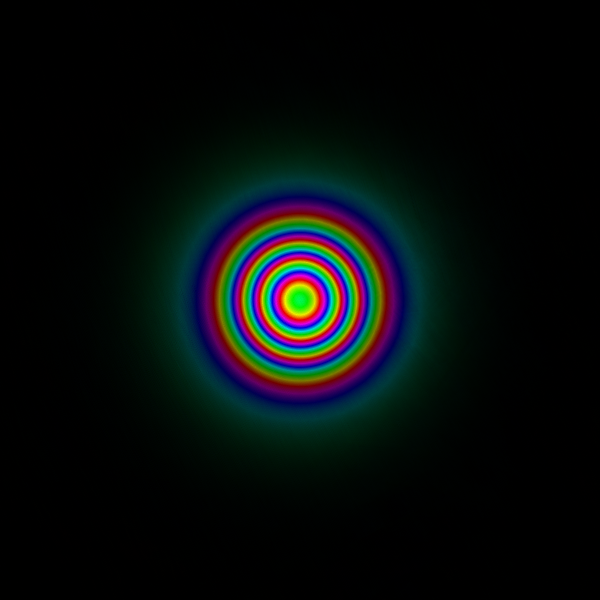

In [20]:
simshow(Array(reconstruction.probe[:, :, 1,1,1,1]))

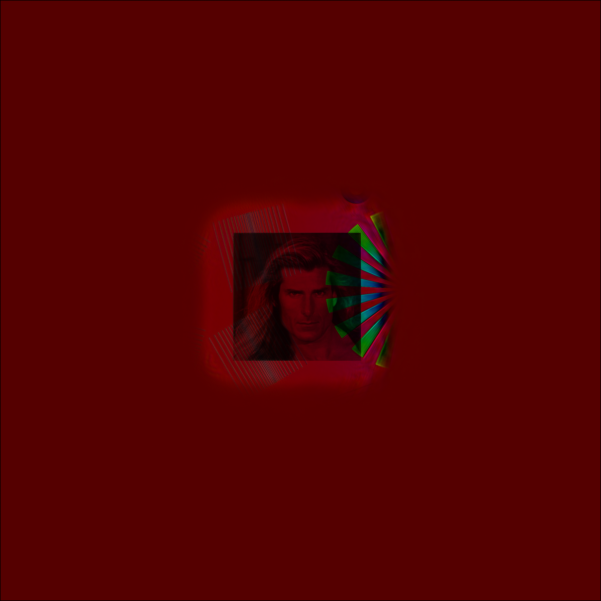

In [21]:
simshow(Array(o[:, :, 1,1,1,1]))